## **HW Final: Test de estrés**

### Pablo Soler Macías, Carlos Daniel García Lavanga y Álvaro Payo Bastante

## **1. Importar librerías y datos**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_parquet('/content/drive/MyDrive/DS for Credit Risk Analytics/prosperLoanData_processed_train.parquet')
df_val = pd.read_parquet('/content/drive/MyDrive/DS for Credit Risk Analytics/prosperLoanData_processed_val.parquet')
df_oot = pd.read_parquet('/content/drive/MyDrive/DS for Credit Risk Analytics/prosperLoanData_processed_oot.parquet')

In [ ]:
#drop indeterminates
df_train = df_train.loc[df_train.indeterm==False]
df_val = df_val.loc[df_val.indeterm==False]
df_oot = df_oot.loc[df_oot.indeterm==False]

In [ ]:
#get the serialized data from previous session
import pickle
input_d2  = pickle.load(open('/content/drive/MyDrive/DS for Credit Risk Analytics/output_HW5 (1).pkl', 'rb'))
corr_data, features = input_d2['corr_data'], input_d2['features']
df_iv, df_psi = input_d2['iv_df'], input_d2['psi_df']

## **2. Limpieza de variables**

### **2.1. Eliminación de variables altamente correlacionadas**

In [ ]:
#run through the iv ranking, and drop features if they are correlated with any feature with better ranking
feats_sorted = df_iv.feature.values.tolist()

def get_uncorr_feats(corr_data, feats_sorted):
    """Handles the corr_data structure, to drop highlly correlated features
    
    Args:
        corr_data: List of tuples containing the correlation info
        feats_sorted: List, with the features to be sorted / dropped
        
    Returns:
        List with the features that have no correlation
    """
    features_keep = feats_sorted[:1]
    for feat in feats_sorted[1:]:
        #capture the correlation tuple
        crr_data = [crr for crr in corr_data if crr[0] == feat]
        if len(crr_data):
            #if there is a 'hit' with a feature in features_keep, do not include it
            hit = len(set(crr_data[0][2].index.tolist()) & set(features_keep)) > 0
            if hit:
                print ('Drop: ' + feat)
            else:
                features_keep.append(feat)    
        else:
            features_keep.append(feat)
    return features_keep

features_keep = get_uncorr_feats(corr_data, feats_sorted)

Drop: TotalProsperPaymentsBilled
Drop: CreditScoreRangeUpper
Drop: OpenCreditLines
Drop: OpenRevolvingAccounts
Drop: TotalCreditLinespast7years


In [ ]:
len(features), len(features_keep), len(corr_data)

(45, 40, 9)

### **2.2. Eliminación de variables con IV bajo**

In [ ]:
df_iv.head()

,feature,IV
29,IncomeRange,0.145180
31,StatedMonthlyIncome,0.119612
34,OnTimeProsperPayments,0.113475
28,DebtToIncomeRatio,0.111675
39,ScorexChangeAtTimeOfListing,0.108946


In [ ]:
#IV < 0.02
def lowIVFeatures(df_iv, th = 0.02):
    """Returns a list with the features that have an IV lower that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    return df_iv.loc[df_iv["IV"]<th].feature.tolist()

In [ ]:
#capture low IV features
low_iv_feats = lowIVFeatures(df_iv)
features_keep_iv = list(set(features_keep) - set(low_iv_feats))
len(features), len(features_keep), len(features_keep_iv)

(45, 40, 23)

### **2.3. Eliminación de variables con PSI elevado**

In [ ]:
df_psi.head()

,feature,PSI
42,Recommendations,0.000000e+00
21,PublicRecordsLast12Months,5.352324e-09
41,PercentFunded,2.141008e-08
20,PublicRecordsLast10Years,2.724033e-05
18,AmountDelinquent,7.428038e-05


In [ ]:
#PSI > 0.25
def highPSIFeatures(df_psi, TH_PSI = 0.25):
    """Returns a list with the features that have a PSI higher that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    return df_psi.loc[df_psi["PSI"] > TH_PSI].feature.tolist()

In [ ]:
#capture high (unstable) features
high_psi_features = highPSIFeatures(df_psi)
features_keep_psi = list(set(features_keep_iv) - set(high_psi_features))
len(features), len(features_keep), len(features_keep_iv), len(features_keep_psi)

(45, 40, 23, 21)

### **2.4. Variables finales con las que trabajaremos**

In [ ]:
#Nos quedamos con 21 variables, que son las que han pasado los filtros de correlación, IV bajo y PSI elevado.
final_features = features_keep_psi
final_features

['CreditScoreRangeLower',
 'ProsperPrincipalOutstanding',
 'TotalTrades',
 'IsBorrowerHomeowner',
 'DebtToIncomeRatio',
 'CurrentlyInGroup',
 'ProsperPaymentsOneMonthPlusLate',
 'AmountDelinquent',
 'TotalProsperLoans',
 'OnTimeProsperPayments',
 'IncomeRange',
 'TradesOpenedLast6Months',
 'CurrentCreditLines',
 'InquiriesLast6Months',
 'ProsperPaymentsLessThanOneMonthLate',
 'ProsperPrincipalBorrowed',
 'StatedMonthlyIncome',
 'IncomeVerifiable',
 'BorrowerState',
 'Occupation',
 'ScorexChangeAtTimeOfListing']

## **3. Preprocesado y trameado**

### **3.1. Variables numéricas**

In [ ]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

### **3.2. Variables categóricas**

In [ ]:
def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

## **4. Trameado**

In [ ]:
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes in (object, bool):
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        print(feature)
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

In [ ]:
dict_bucketing = get_bucketing_allfeatures(df_train, final_features, n_bins=4)
dict_bucketing

CreditScoreRangeLower
ProsperPrincipalOutstanding
TotalTrades
IsBorrowerHomeowner
DebtToIncomeRatio
CurrentlyInGroup
ProsperPaymentsOneMonthPlusLate
AmountDelinquent
TotalProsperLoans
OnTimeProsperPayments
IncomeRange
TradesOpenedLast6Months
CurrentCreditLines
InquiriesLast6Months
ProsperPaymentsLessThanOneMonthLate
ProsperPrincipalBorrowed
StatedMonthlyIncome
IncomeVerifiable
BorrowerState
Occupation
ScorexChangeAtTimeOfListing


{'CreditScoreRangeLower': [600.0, 660.0, 700.0, 740.0, 880.0],
 'ProsperPrincipalOutstanding': [0.0, 817.575, 3049.0924999999997, 21523.79],
 'TotalTrades': [1.0, 14.0, 21.0, 30.0, 110.0],
 'IsBorrowerHomeowner': [True, False],
 'DebtToIncomeRatio': [0.0, 0.13, 0.19, 0.29, 10.01],
 'CurrentlyInGroup': [False, True],
 'ProsperPaymentsOneMonthPlusLate': [0.0, 21.0],
 'AmountDelinquent': [0.0, 249209.0],
 'TotalProsperLoans': [0.0, 1.0, 2.0, 7.0],
 'OnTimeProsperPayments': [0.0, 10.0, 19.0, 34.0, 103.0],
 'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'TradesOpenedLast6Months': [0.0, 1.0, 20.0],
 'CurrentCreditLines': [0.0, 6.0, 9.0, 12.0, 38.0],
 'InquiriesLast6Months': [0.0, 1.0, 2.0, 27.0],
 'ProsperPaymentsLessThanOneMonthLate': [0.0, 28.0],
 'ProsperPrincipalBorrowed': [0.0, 3000.0, 5000.0, 9000.0, 57499.0],
 'StatedMonthlyIncome': [0.0,
  3166.666667,
  4666.666667,
  6833.333333,
  483333.333333],
 'IncomeVerifiable': [True, False],
 'Bor

In [ ]:
len(final_features), len(dict_bucketing.keys())

(21, 21)

In [ ]:
def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes in (object, bool):
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [ ]:
apply_bucketing(df_train, 'CreditScoreRangeLower', dict_bucketing['CreditScoreRangeLower']).head()

,CreditScoreRangeLower_660|700,CreditScoreRangeLower_700|740,CreditScoreRangeLower_740|880
0,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0
5,0,0,1


In [ ]:
#Apply the bucketing

# Keep each column dummy columns in independent lists
list_df_tr, list_df_val, list_df_oot = [], [], []
for feat in final_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_val_preproc = pd.concat(list_df_val, axis=1)
df_oot_preproc = pd.concat(list_df_oot, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [ ]:
df_tr_preproc.shape, df_oot_preproc.shape

((15259, 56), (13220, 58))

In [ ]:
# Capture the target in each subset
y_tr, y_val, y_oot = df_train['bad'], df_val['bad'], df_oot['bad']

## **5. Random Forest con datos originales**

In [ ]:
# Lighther preprocessing
# Handle NAs @ numeric features
# fill with a value lower than its minimum
# We can reuse previopus categorical preprocessing

dtypes = df_train[final_features].dtypes
cat_features = df_train[final_features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_feats = [f for f in final_features if f not in cat_features]

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [ ]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [ ]:
# Keep each column dummy columns in independent lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val, list_df_oot = [df_train_fill[num_feats]], [df_val_fill[num_feats]], [df_oot_fill[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf = pd.concat(list_df_val, axis=1)
df_oot_preproc_rf = pd.concat(list_df_oot, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

In [ ]:
df_tr_preproc_rf.columns

Index(['CreditScoreRangeLower', 'ProsperPrincipalOutstanding', 'TotalTrades',
       'DebtToIncomeRatio', 'ProsperPaymentsOneMonthPlusLate',
       'AmountDelinquent', 'TotalProsperLoans', 'OnTimeProsperPayments',
       'TradesOpenedLast6Months', 'CurrentCreditLines', 'InquiriesLast6Months',
       'ProsperPaymentsLessThanOneMonthLate', 'ProsperPrincipalBorrowed',
       'StatedMonthlyIncome', 'ScorexChangeAtTimeOfListing',
       'IsBorrowerHomeowner_True', 'CurrentlyInGroup_True',
       'IncomeRange_$25,000-49,999', 'IncomeRange_$50,000-74,999',
       'IncomeRange_$75,000-99,999', 'IncomeRange_Other',
       'IncomeVerifiable_True', 'BorrowerState_FL', 'BorrowerState_NY',
       'BorrowerState_Other', 'BorrowerState_TX', 'Occupation_Executive',
       'Occupation_Other', 'Occupation_Professional'],
      dtype='object')

In [ ]:
len(keep_cols_rf)

29

In [ ]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [ ]:
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

X_tr = df_tr_preproc_rf[keep_cols_rf]
X_val = df_val_preproc_rf[keep_cols_rf]
X_oot = df_oot_preproc_rf[keep_cols_rf]

rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=300, 
                            max_depth=4, 
                            n_jobs=4)
rf.fit(X_tr, y_tr)

# Predict for all subsets
pred_rf_tr = rf.predict_proba(X_tr)[:, 1]
pred_rf_val = rf.predict_proba(X_val)[:, 1] 
pred_rf_oot = rf.predict_proba(X_oot)[:, 1]

# Get AUC metrics in all subsets
rf_aucs = get_auc(y_tr, pred_rf_tr), get_auc(y_val, pred_rf_val), get_auc(y_oot, pred_rf_oot)
rf_aucs

(0.7327563261829493, 0.7081452016543293, 0.7021567003549735)

In [ ]:
Media_scores_OG = pred_rf_oot.mean()
Media_scores_OG

0.0696955183881404

In [ ]:
Num_bads_OG = pred_rf_oot.sum()
Num_bads_OG

921.3747530912161

In [ ]:
#Show Feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': rf.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

,feature,importance
13,StatedMonthlyIncome,0.199030
10,InquiriesLast6Months,0.101220
9,CurrentCreditLines,0.091803
0,CreditScoreRangeLower,0.090604
14,ScorexChangeAtTimeOfListing,0.090599
7,OnTimeProsperPayments,0.074289
3,DebtToIncomeRatio,0.074243
8,TradesOpenedLast6Months,0.041736
21,IncomeVerifiable_True,0.040366
17,"IncomeRange_$25,000-49,999",0.034756


## **6. Transformación de variables StatedMonthlyIncome & IncomeRange**

Tras realizar el preprocesado y el trameado con los datos originales, para posteriormente hacer un Random Forest, hemos obtenido un AUC en torno al 70%; un score medio, es decir, la probabilidad de que sea bad, de 6.9%; y 920 bads. 

Ahora vamos a reducir los valores de la variable StatedMonthlyIncome para validation y OOT en un 5%, 10% y 20%, y ajustaremos la variable IncomeRange con la función categorise que hemos creado en este apartado. 

El objetivo de esto es realizar nuevas predicciones con la muestra de OOT modificada y ver como afecta al score medio y a los bads esperados en cada caso.

In [ ]:
df_val95 = df_val.copy()
df_oot95 = df_oot.copy()

df_val90 = df_val.copy()
df_oot90 = df_oot.copy()

df_val80 = df_val.copy()
df_oot80 = df_oot.copy()

In [ ]:
df_val95['StatedMonthlyIncome'] = df_val95['StatedMonthlyIncome'] * 0.95
df_oot95['StatedMonthlyIncome'] = df_oot95['StatedMonthlyIncome'] * 0.95

df_val90['StatedMonthlyIncome'] = df_val90['StatedMonthlyIncome'] * 0.9
df_oot90['StatedMonthlyIncome'] = df_oot90['StatedMonthlyIncome'] * 0.9

df_val80['StatedMonthlyIncome'] = df_val80['StatedMonthlyIncome'] * 0.8
df_oot80['StatedMonthlyIncome'] = df_oot80['StatedMonthlyIncome'] * 0.8

Reducimos el StatedMonthlyIncome de las muestras de OOT y de validation en un 5%, 10% y 20% multiplicando la variable por 0.95, 0.9 y 0.8, respectivamente.

In [ ]:
def categorise(row):  
    if row['StatedMonthlyIncome']*12 > 0 and row['StatedMonthlyIncome']*12 <= 24999: 
        return '$1-24,999'
    elif row['StatedMonthlyIncome']*12 > 25000 and row['StatedMonthlyIncome']*12 <= 49999:
        return '$25,000-49,999'
    elif row['StatedMonthlyIncome']*12 > 50000 and row['StatedMonthlyIncome']*12 <= 74999:
        return '$50,000-74,999'
    elif row['StatedMonthlyIncome']*12 > 75000 and row['StatedMonthlyIncome']*12 <= 99999:
        return '$75,000-99,999'
    elif row['StatedMonthlyIncome']*12 > 100000:
        return '$100,000+'
    return '$0'

In [ ]:
df_val95['IncomeRange'] = df_val95.apply(lambda row: categorise(row), axis=1)
df_oot95['IncomeRange'] = df_oot95.apply(lambda row: categorise(row), axis=1)

df_val90['IncomeRange'] = df_val90.apply(lambda row: categorise(row), axis=1)
df_oot90['IncomeRange'] = df_oot90.apply(lambda row: categorise(row), axis=1)

df_val80['IncomeRange'] = df_val80.apply(lambda row: categorise(row), axis=1)
df_oot80['IncomeRange'] = df_oot80.apply(lambda row: categorise(row), axis=1)

Realizamos una función en la que ajustamos las categorías de IncomeRange, de manera que al reducir StatedMonthlyIncome, las categorías de IncomeRange se reclasificarán. Hemos juntado las categorías de Not Employed y de 0 dólares en  la de 0 dólares.

In [ ]:
df_train['IncomeRange'].value_counts()

$25,000-49,999    4723
$50,000-74,999    4360
$100,000+         2427
$75,000-99,999    2375
$1-24,999         1167
Not employed       193
$0                  14
Name: IncomeRange, dtype: int64

In [ ]:
df_val['IncomeRange'].value_counts()

$25,000-49,999    1624
$50,000-74,999    1430
$100,000+          800
$75,000-99,999     778
$1-24,999          367
Not employed        74
$0                   8
Name: IncomeRange, dtype: int64

In [ ]:
df_val95['IncomeRange'].value_counts()

$25,000-49,999    1805
$50,000-74,999    1348
$75,000-99,999     744
$100,000+          641
$1-24,999          461
$0                  82
Name: IncomeRange, dtype: int64

In [ ]:
df_oot['IncomeRange'].value_counts()

$25,000-49,999    3839
$50,000-74,999    3749
$100,000+         2418
$75,000-99,999    2164
$1-24,999          872
Not employed       173
$0                   5
Name: IncomeRange, dtype: int64

In [ ]:
df_oot95['IncomeRange'].value_counts()

$25,000-49,999    4354
$50,000-74,999    3512
$75,000-99,999    2109
$100,000+         1943
$1-24,999         1124
$0                 178
Name: IncomeRange, dtype: int64

Mediante los value_counts sobre los datos originales y los datos transformados, podemos ver como varían las categorías de la variable IncomeRange en validation y OOT.

Podemos ver como tras las transformaciones en validation y OOT, los rangos de salarios más altos disminuyen y los de salarios más bajos aumentan.

## **7. Reducción de StatedMonthlyIncome en un 5%**

In [ ]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill95 = apply_nafill_rf_num(df_val95, dict_nafill)
df_oot_fill95 = apply_nafill_rf_num(df_oot95, dict_nafill)

In [ ]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val95, list_df_oot95 = [df_train_fill[num_feats]], [df_val_fill95[num_feats]], [df_oot_fill95[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val95.append(apply_bucketing(df_val95, feat, dict_bucketing[feat]))
    list_df_oot95.append(apply_bucketing(df_oot95, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf95 = pd.concat(list_df_val95, axis=1)
df_oot_preproc_rf95 = pd.concat(list_df_oot95, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

In [ ]:
#Da error con validation y dijo que solo le importaba OOT, por lo que solo hago la prediccion para OOT
X_oot95 = df_oot_preproc_rf95[keep_cols_rf]

In [ ]:
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=300, 
                            max_depth=4, 
                            n_jobs=4)
rf.fit(X_tr, y_tr)

# Predict for OOT
pred_rf_oot95 = rf.predict_proba(X_oot95)[:, 1]

# Get AUC metrics in all subsets
rf_aucs95 = get_auc(y_oot, pred_rf_oot95)
rf_aucs95

0.7007096195648392

In [ ]:
Media_scores_95 = pred_rf_oot95.mean()
Media_scores_95 #probabilidad de que sea bad

0.07058470945996159

In [ ]:
Num_bads_95 = pred_rf_oot95.sum()
Num_bads_95 #probabilidad de que sea bad x número de clientes (length oot) = bads esperados

933.1298590606922

## **8. Reducción de StatedMonthlyIncome en un 10%**

In [ ]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill90 = apply_nafill_rf_num(df_val90, dict_nafill)
df_oot_fill90 = apply_nafill_rf_num(df_oot90, dict_nafill)

In [ ]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val90, list_df_oot90 = [df_train_fill[num_feats]], [df_val_fill90[num_feats]], [df_oot_fill90[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val90.append(apply_bucketing(df_val90, feat, dict_bucketing[feat]))
    list_df_oot90.append(apply_bucketing(df_oot90, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf90 = pd.concat(list_df_val90, axis=1)
df_oot_preproc_rf90 = pd.concat(list_df_oot90, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

In [ ]:
#Da error con validation y dijo que solo le importaba OOT, por lo que solo hago la prediccion para OOT
X_oot90 = df_oot_preproc_rf90[keep_cols_rf]

In [ ]:
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=300, 
                            max_depth=4, 
                            n_jobs=4)
rf.fit(X_tr, y_tr)

# Predict for OOT
pred_rf_oot90 = rf.predict_proba(X_oot90)[:, 1]

# Get AUC metrics in all subsets
rf_aucs90 = get_auc(y_oot, pred_rf_oot90)
rf_aucs90

0.698945598152648

In [ ]:
Media_scores_90 = pred_rf_oot90.mean()
Media_scores_90

0.07173622471298186

In [ ]:
Num_bads_90 = pred_rf_oot90.sum()
Num_bads_90

948.3528907056201

## **9. Reducción de StatedMonthlyIncome en un 20%**

In [ ]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill80 = apply_nafill_rf_num(df_val80, dict_nafill)
df_oot_fill80 = apply_nafill_rf_num(df_oot80, dict_nafill)

In [ ]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val80, list_df_oot80 = [df_train_fill[num_feats]], [df_val_fill80[num_feats]], [df_oot_fill80[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val80.append(apply_bucketing(df_val80, feat, dict_bucketing[feat]))
    list_df_oot80.append(apply_bucketing(df_oot80, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf80 = pd.concat(list_df_val80, axis=1)
df_oot_preproc_rf80 = pd.concat(list_df_oot80, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

In [ ]:
#Creo la columna llena de 0s ya que me dice que no está en el índice al crear X_oot80
df_oot_preproc_rf80_2 = df_oot_preproc_rf80.copy()
df_oot_preproc_rf80_2['IncomeRange_$75,000-99,999'] = 0

In [ ]:
#Aqui si que me da error con oot, por lo que creo la columna con 0 (nos dio el visto bueno)
X_oot80 = df_oot_preproc_rf80_2[keep_cols_rf]

In [ ]:
# SOLUCION
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, 
                            min_samples_leaf=300, 
                            max_depth=4, 
                            n_jobs=4)
rf.fit(X_tr, y_tr)

# Predict for OOT
pred_rf_oot80 = rf.predict_proba(X_oot80)[:, 1]

# Get AUC metrics in all subsets
rf_aucs80 = get_auc(y_oot, pred_rf_oot80)
rf_aucs80

0.6944295396231542

In [ ]:
Media_scores_80 = pred_rf_oot80.mean()
Media_scores_80

0.07424550442203896

In [ ]:
Num_bads_80 = pred_rf_oot80.sum()
Num_bads_80

981.5255684593551

## **10. Comparaciones AUC, scores y bads esperados**

### **10.1. DataFrame y conclusiones**

In [ ]:
rf_auc_oot_OG = get_auc(y_oot, pred_rf_oot)

In [ ]:
df_mix = pd.DataFrame()

Scores_medios = (Media_scores_OG, Media_scores_95, Media_scores_90, Media_scores_80)
Bads_esperados = (Num_bads_OG, Num_bads_95, Num_bads_90, Num_bads_80)
AUC_OOT = (rf_auc_oot_OG, rf_aucs95, rf_aucs90, rf_aucs80)

df_mix["AUC"] = AUC_OOT
df_mix["Scores_medios"] = Scores_medios
df_mix["Bads_esperados"] = Bads_esperados
df_mix.index = ["Datos originales", "Reduccion 5%", "Reduccion 10%", "Reduccion 20%"]
df_mix['Bads_esperados'] = df_bads['Bads_esperados'].round(0)

df_mix

,AUC,Scores_medios,Bads_esperados
Datos originales,0.702157,0.069696,921.0
Reduccion 5%,0.700710,0.070585,933.0
Reduccion 10%,0.698946,0.071736,948.0
Reduccion 20%,0.694430,0.074246,982.0


Tras haber estimado los Random Forest con los tres escenarios, podemos ver que todos tienen un resultado aceptable para las predicciones de OOT. En todos los casos, **el AUC se encuentra alrededor del 70%**, lo que nos indica que no clasifica aleatoriamente, pero tampoco clasifica de manera perfecta.

Respecto a **los scores medios y a los bads esperados** para cada escenario, podemos ver como **van aumentando a medida que vamos reduciendo la variable StatedMonthlyIncome**. Esto se debe a que, si reducimos los ingresos de los clientes, algunos de ellos tendrán problemas para pagar sus préstamos y por ello, habrá una mayor cantidad de impagos. **Si siguiésemos reduciendo los ingresos a los clientes, los scores medios y los bads esperados seguirían aumentando.**

### **10.2. Gráficos**

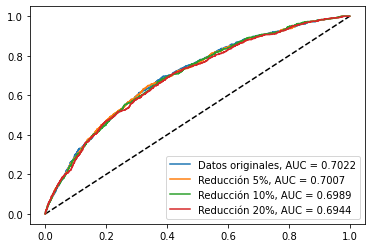

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_oot, pred_rf_oot)
fpr95, tpr95, _ = metrics.roc_curve(y_oot, pred_rf_oot95)
fpr90, tpr90, _ = metrics.roc_curve(y_oot, pred_rf_oot90)
fpr80, tpr80, _ = metrics.roc_curve(y_oot, pred_rf_oot80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label="Datos originales, AUC = "+str(rf_auc_oot_OG.round(4)))
plt.plot(fpr95,tpr95,label="Reducción 5%, AUC = "+str(rf_aucs95.round(4)))
plt.plot(fpr90,tpr90,label="Reducción 10%, AUC = "+str(rf_aucs90.round(4)))
plt.plot(fpr80,tpr80,label="Reducción 20%, AUC = "+str(rf_aucs80.round(4)))
plt.legend(loc=4)
plt.show()

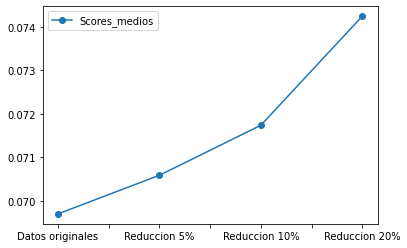

In [ ]:
df_mix['Scores_medios'].plot(legend=True,marker='o', color = )

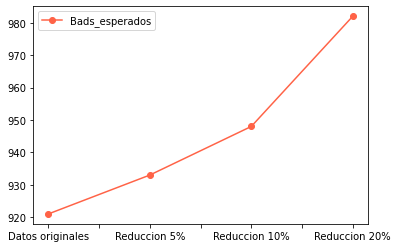

In [ ]:
df_mix['Bads_esperados'].plot(legend=True,marker='o', color = "tomato")